# Customer Segmentation Analysis

This notebook performs K-means clustering on customer data to create distinct customer profiles and export a mapping of customers to their assigned profiles.

## 1. Import Required Libraries

Import necessary libraries including pandas, numpy, scikit-learn, matplotlib, and seaborn for data manipulation, clustering, and visualization.

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Customer Dataset

Load the customer dataset using pandas and display basic information about the data structure and contents.

In [20]:
# Load customer dataset
customer_data = pd.read_csv('data/Customer_0_RV.csv')

print("Customer Dataset Overview:")
print(f"Shape: {customer_data.shape}")
print(f"Columns: {customer_data.columns.tolist()}")

print("\nFirst few rows:")
print(customer_data.head())

print("\nDataset Info:")
print(customer_data.info())

print("\nBasic Statistics:")
print(customer_data.describe())

Customer Dataset Overview:
Shape: (190339, 7)
Columns: ['customer_key', 'MarriedIndicator', 'SinceDate', 'SinceDateBinned', 'HomeownerFlag', 'RetailFlag', 'OccupationCode']

First few rows:
   customer_key MarriedIndicator            SinceDate  SinceDateBinned  \
0       5973888                S  2012-03-01 00:00:00                2   
1       2458586                S  2004-06-01 00:00:00                5   
2       6365820                S  2014-02-01 00:00:00                6   
3       5959280                M  2010-04-01 00:00:00                2   
4       6568472                M  2013-10-01 00:00:00                6   

  HomeownerFlag RetailFlag  OccupationCode  
0             5          Y               0  
1             5          Y               0  
2             5          Y               0  
3             4          Y              52  
4             2          Y              52  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190339 entries, 0 to 190338
Da

## 3. Data Exploration and Preprocessing

Explore the dataset, handle missing values, scale numerical features, and prepare the data for clustering analysis.

Missing values per column:
customer_key        0
MarriedIndicator    0
SinceDate           0
SinceDateBinned     0
HomeownerFlag       0
RetailFlag          0
OccupationCode      0
dtype: int64

Data types:
customer_key         int64
MarriedIndicator    object
SinceDate           object
SinceDateBinned      int64
HomeownerFlag       object
RetailFlag          object
OccupationCode       int64
dtype: object

Features for clustering: ['MarriedIndicator', 'SinceDate', 'SinceDateBinned', 'HomeownerFlag', 'RetailFlag', 'OccupationCode']

Categorical columns: ['MarriedIndicator', 'SinceDate', 'HomeownerFlag', 'RetailFlag']
Numerical columns: ['SinceDateBinned', 'OccupationCode']

Encoded categorical variables: ['MarriedIndicator', 'SinceDate', 'HomeownerFlag', 'RetailFlag']


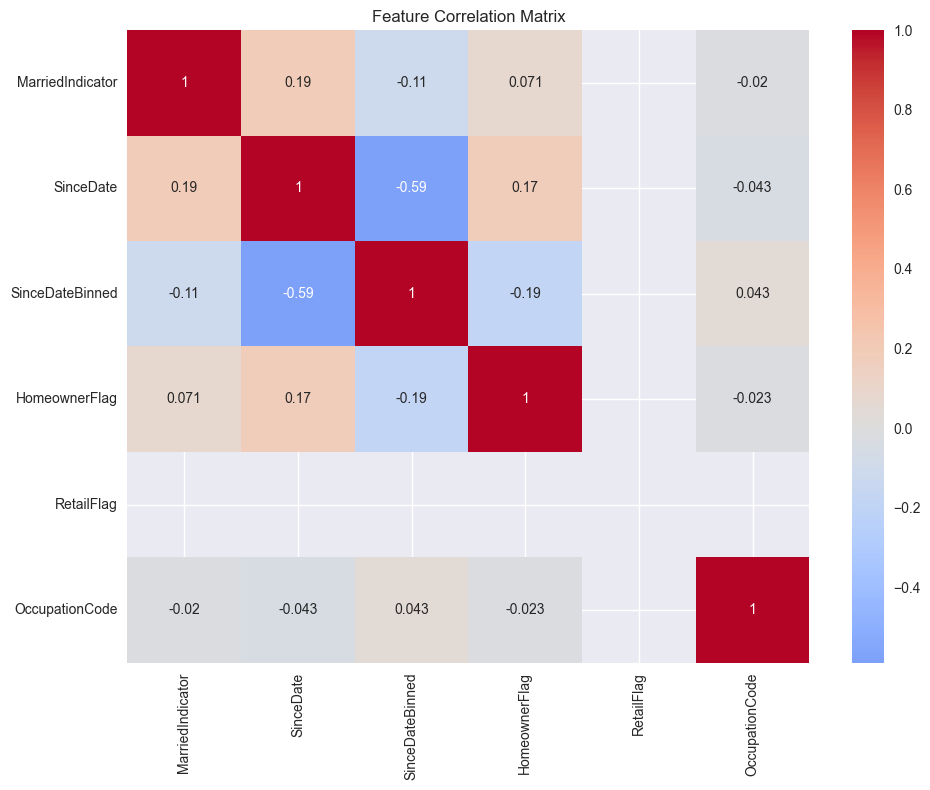


Data ready for clustering:
   MarriedIndicator  SinceDate  SinceDateBinned  HomeownerFlag  RetailFlag  \
0                 5        563                2              5           0   
1                 5        470                5              5           0   
2                 5        586                6              5           0   
3                 3        540                2              4           0   
4                 3        582                6              2           0   

   OccupationCode  
0               0  
1               0  
2               0  
3              52  
4              52  


In [21]:
# Check for missing values
print("Missing values per column:")
print(customer_data.isnull().sum())

# Analyze categorical and numerical columns
print("\nData types:")
print(customer_data.dtypes)

# Separate features for clustering (exclude customer_key)
features_for_clustering = customer_data.drop(['customer_key'], axis=1)

print(f"\nFeatures for clustering: {features_for_clustering.columns.tolist()}")

# Handle categorical variables
categorical_cols = features_for_clustering.select_dtypes(include=['object']).columns
numerical_cols = features_for_clustering.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical columns: {categorical_cols.tolist()}")
print(f"Numerical columns: {numerical_cols.tolist()}")

# Prepare data for clustering
clustering_data = features_for_clustering.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    clustering_data[col] = le.fit_transform(clustering_data[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded categorical variables: {categorical_cols.tolist()}")

# Display correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = clustering_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nData ready for clustering:")
print(clustering_data.head())

In [22]:
# Scale the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)

print(f"Scaled features shape: {scaled_features.shape}")
print(f"Feature means after scaling: {scaled_features.mean(axis=0)}")
print(f"Feature standard deviations after scaling: {scaled_features.std(axis=0)}")

# Create a DataFrame with scaled features for easier handling
scaled_df = pd.DataFrame(scaled_features, columns=clustering_data.columns)
print("\nScaled data preview:")
print(scaled_df.head())

Scaled features shape: (190339, 6)
Feature means after scaling: [ 2.83113608e-16 -8.12309087e-17  1.99194912e-16  5.13666040e-17
  0.00000000e+00  3.82263100e-17]
Feature standard deviations after scaling: [1. 1. 1. 1. 0. 1.]

Scaled data preview:
   MarriedIndicator  SinceDate  SinceDateBinned  HomeownerFlag  RetailFlag  \
0          0.878685   0.814790        -1.509732       0.366521         0.0   
1          0.878685  -0.033960        -0.091796       0.366521         0.0   
2          0.878685   1.024696         0.380850       0.366521         0.0   
3         -0.933369   0.604884        -1.509732      -0.164838         0.0   
4         -0.933369   0.988191         0.380850      -1.227557         0.0   

   OccupationCode  
0       -0.329702  
1       -0.329702  
2       -0.329702  
3        3.909924  
4        3.909924  


## 4. Determine Optimal Number of Clusters

Use the elbow method and silhouette analysis to determine the optimal number of clusters for K-means.

Calculating for k=2...
Calculating for k=3...
Calculating for k=3...
Calculating for k=4...
Calculating for k=4...
Calculating for k=5...
Calculating for k=5...
Calculating for k=6...
Calculating for k=6...
Calculating for k=7...
Calculating for k=7...
Calculating for k=8...
Calculating for k=8...
Calculating for k=9...
Calculating for k=9...
Calculating for k=10...
Calculating for k=10...


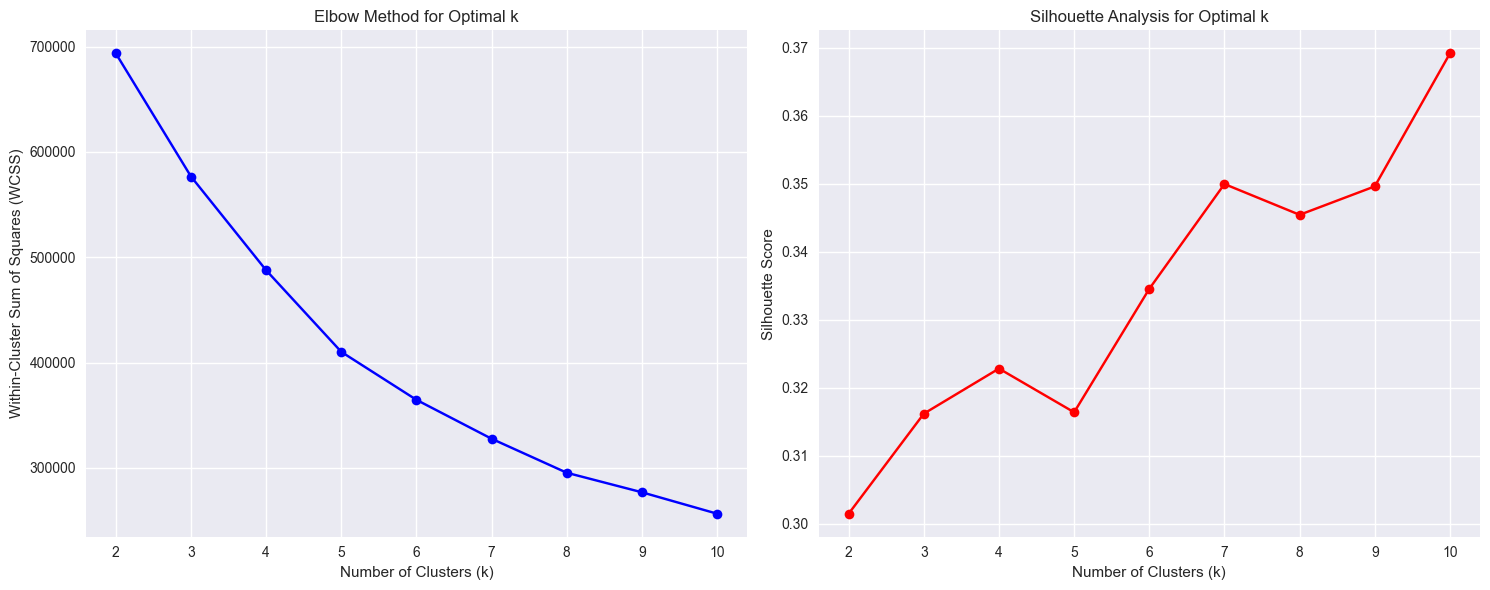


Elbow Method Results:
k=2: WCSS=693438.86, Silhouette Score=0.301
k=3: WCSS=576570.30, Silhouette Score=0.316
k=4: WCSS=487587.57, Silhouette Score=0.323
k=5: WCSS=410136.97, Silhouette Score=0.316
k=6: WCSS=364591.22, Silhouette Score=0.335
k=7: WCSS=327655.00, Silhouette Score=0.350
k=8: WCSS=295384.16, Silhouette Score=0.345
k=9: WCSS=276848.78, Silhouette Score=0.350
k=10: WCSS=256527.17, Silhouette Score=0.369

Optimal number of clusters based on silhouette score: 10
Best silhouette score: 0.369


In [23]:
# Elbow Method - Calculate WCSS for different number of clusters
k_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in k_range:
    print(f"Calculating for k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print results
print("\nElbow Method Results:")
for k, w, s in zip(k_range, wcss, silhouette_scores):
    print(f"k={k}: WCSS={w:.2f}, Silhouette Score={s:.3f}")

# Find optimal k based on highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

## 5. Apply K-Means Clustering

Implement K-means clustering with the optimal number of clusters and assign cluster labels to each customer.

K-means clustering applied with 10 clusters
Final silhouette score: 0.369

Cluster distribution:
0    20183
1    24167
2     8478
3    33006
4    40021
5     9024
6    12923
7    22231
8     9850
9    10456
Name: count, dtype: int64
Final silhouette score: 0.369

Cluster distribution:
0    20183
1    24167
2     8478
3    33006
4    40021
5     9024
6    12923
7    22231
8     9850
9    10456
Name: count, dtype: int64


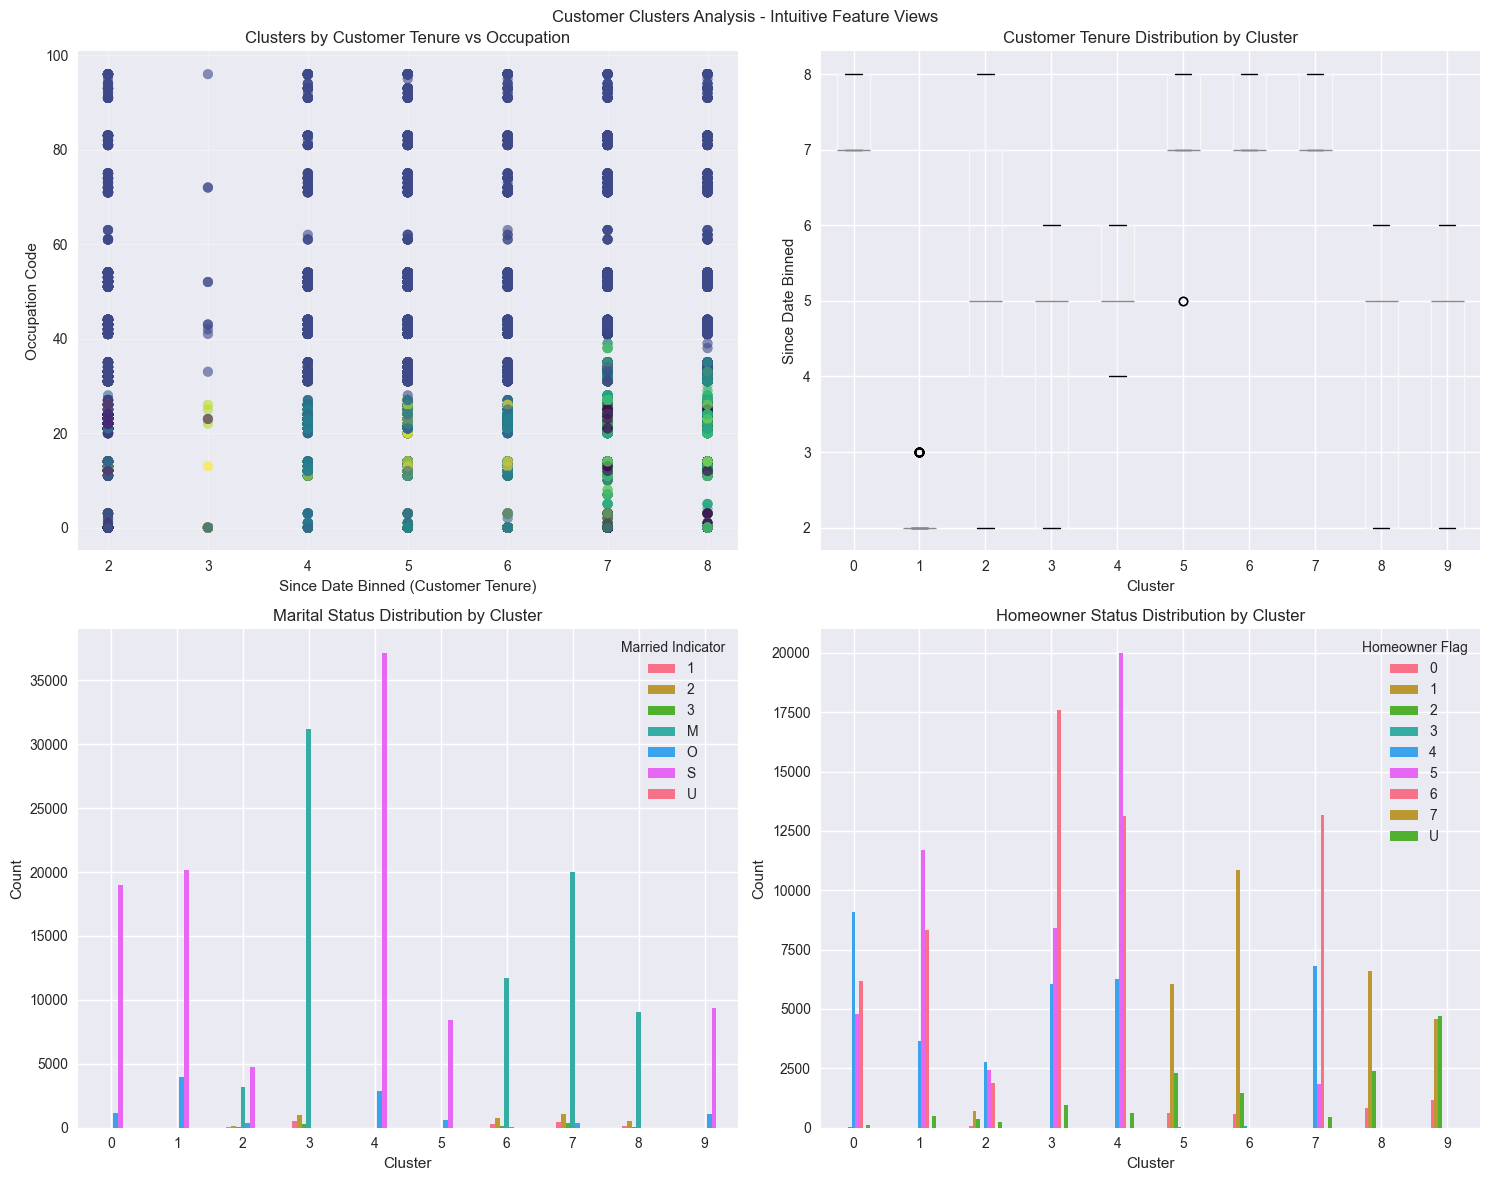


CLUSTER SUMMARY FOR INTUITIVE UNDERSTANDING

CLUSTER 0 (20,183 customers, 10.6%)
--------------------------------------------------
Most common marital status: S
Most common homeowner flag: 4
Most common retail flag: Y
Average customer tenure (SinceDateBinned): 7.5
Most common occupation codes: [0, 23, 24]

CLUSTER 1 (24,167 customers, 12.7%)
--------------------------------------------------
Most common marital status: S
Most common homeowner flag: 5
Most common retail flag: Y
Average customer tenure (SinceDateBinned): 2.0
Most common occupation codes: [0, 23, 24]

CLUSTER 2 (8,478 customers, 4.5%)
--------------------------------------------------
Most common marital status: S
Most common homeowner flag: 4
Most common retail flag: Y
Average customer tenure (SinceDateBinned): 5.2
Most common occupation codes: [33, 52, 54]

CLUSTER 3 (33,006 customers, 17.3%)
--------------------------------------------------
Most common marital status: M
Most common homeowner flag: 6
Most common reta

In [24]:
# Apply K-means clustering with optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to original dataset
customer_data_clustered = customer_data.copy()
customer_data_clustered['cluster'] = cluster_labels

print(f"K-means clustering applied with {optimal_k} clusters")
print(f"Final silhouette score: {silhouette_score(scaled_features, cluster_labels):.3f}")

# Display cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)

# Visualize clusters using original features for intuitive understanding
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: SinceDateBinned vs OccupationCode (colored by cluster)
axes[0,0].scatter(customer_data_clustered['SinceDateBinned'], customer_data_clustered['OccupationCode'],
                  c=cluster_labels, cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Since Date Binned (Customer Tenure)')
axes[0,0].set_ylabel('Occupation Code')
axes[0,0].set_title('Clusters by Customer Tenure vs Occupation')
axes[0,0].grid(True, alpha=0.3)

# Box plot: SinceDateBinned by cluster
customer_data_clustered.boxplot(column='SinceDateBinned', by='cluster', ax=axes[0,1])
axes[0,1].set_title('Customer Tenure Distribution by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Since Date Binned')

# Bar plot: MarriedIndicator by cluster
married_cluster = pd.crosstab(customer_data_clustered['cluster'], customer_data_clustered['MarriedIndicator'])
married_cluster.plot(kind='bar', ax=axes[1,0], rot=0)
axes[1,0].set_title('Marital Status Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title='Married Indicator')

# Bar plot: HomeownerFlag by cluster
homeowner_cluster = pd.crosstab(customer_data_clustered['cluster'], customer_data_clustered['HomeownerFlag'])
homeowner_cluster.plot(kind='bar', ax=axes[1,1], rot=0)
axes[1,1].set_title('Homeowner Status Distribution by Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Count')
axes[1,1].legend(title='Homeowner Flag')

plt.suptitle('Customer Clusters Analysis - Intuitive Feature Views')
plt.tight_layout()
plt.show()

# Additional cluster summary for intuitive understanding
print("\n" + "="*60)
print("CLUSTER SUMMARY FOR INTUITIVE UNDERSTANDING")
print("="*60)

for cluster_id in sorted(customer_data_clustered['cluster'].unique()):
    cluster_data = customer_data_clustered[customer_data_clustered['cluster'] == cluster_id]
    size = len(cluster_data)
    pct = size / len(customer_data_clustered) * 100

    print(f"\nCLUSTER {cluster_id} ({size:,} customers, {pct:.1f}%)")
    print("-" * 50)

    # Most common characteristics
    print(f"Most common marital status: {cluster_data['MarriedIndicator'].mode().iloc[0]}")
    print(f"Most common homeowner flag: {cluster_data['HomeownerFlag'].mode().iloc[0]}")
    print(f"Most common retail flag: {cluster_data['RetailFlag'].mode().iloc[0]}")
    print(f"Average customer tenure (SinceDateBinned): {cluster_data['SinceDateBinned'].mean():.1f}")
    print(f"Most common occupation codes: {cluster_data['OccupationCode'].value_counts().head(3).index.tolist()}")

## 6. Analyze Cluster Characteristics

Calculate and visualize the mean characteristics of each cluster to understand what distinguishes each group.

Cluster Characteristics Summary:
        Most_Common_MarriedIndicator  Avg_SinceDateBinned  \
cluster                                                     
0                                  S                 7.49   
1                                  S                 2.00   
2                                  S                 5.18   
3                                  M                 3.96   
4                                  S                 5.09   
5                                  S                 7.48   
6                                  M                 7.41   
7                                  M                 7.40   
8                                  M                 4.14   
9                                  S                 4.08   

        Most_Common_HomeownerFlag Most_Common_RetailFlag  \
cluster                                                    
0                               4                      Y   
1                               5                     

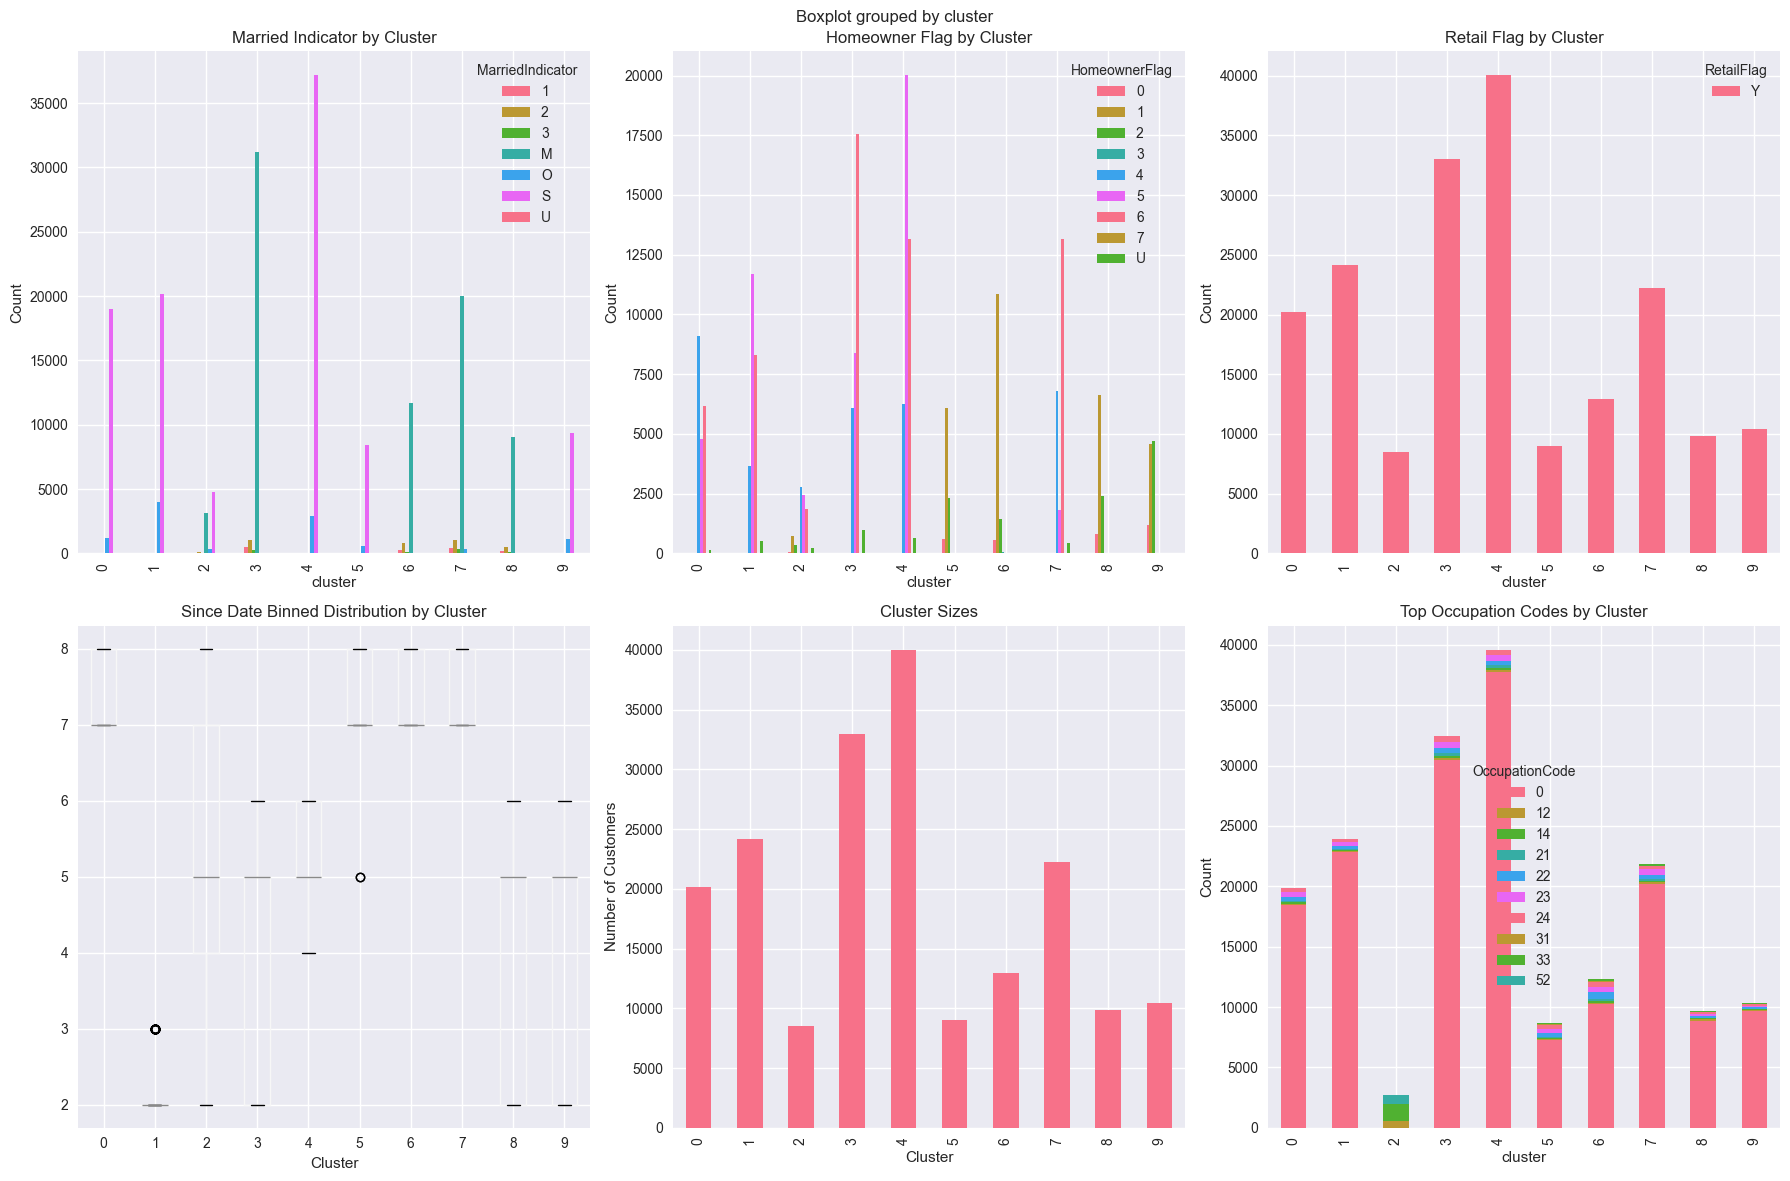

In [29]:
# Analyze cluster characteristics
cluster_analysis = customer_data_clustered.groupby('cluster').agg({
    'MarriedIndicator': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'SinceDateBinned': 'mean',
    'HomeownerFlag': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'RetailFlag': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'OccupationCode': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'customer_key': 'count'
}).round(2)

cluster_analysis.columns = ['Most_Common_MarriedIndicator', 'Avg_SinceDateBinned',
                           'Most_Common_HomeownerFlag', 'Most_Common_RetailFlag',
                           'Most_Common_OccupationCode', 'Customer_Count']

print("Cluster Characteristics Summary:")
print(cluster_analysis)

# Create detailed cluster profiles
print("\n" + "="*80)
print("DETAILED CLUSTER ANALYSIS")
print("="*80)

for cluster_id in sorted(customer_data_clustered['cluster'].unique()):
    cluster_data = customer_data_clustered[customer_data_clustered['cluster'] == cluster_id]

    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(customer_data_clustered)*100:.1f}%)")

    print("\nMarried Indicator Distribution:")
    print(cluster_data['MarriedIndicator'].value_counts(normalize=True).round(3))

    print("\nHomeowner Flag Distribution:")
    print(cluster_data['HomeownerFlag'].value_counts(normalize=True).round(3))

    print("\nRetail Flag Distribution:")
    print(cluster_data['RetailFlag'].value_counts(normalize=True).round(3))

    print(f"\nAverage Since Date Binned: {cluster_data['SinceDateBinned'].mean():.2f}")

    print("\nTop 3 Occupation Codes:")
    top_occupations = cluster_data['OccupationCode'].value_counts().head(3)
    for occ, count in top_occupations.items():
        print(f"  {occ}: {count} customers ({count/len(cluster_data)*100:.1f}%)")

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Married Indicator by Cluster
customer_data_clustered.groupby(['cluster', 'MarriedIndicator']).size().unstack().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Married Indicator by Cluster')
axes[0,0].set_ylabel('Count')

# Homeowner Flag by Cluster
customer_data_clustered.groupby(['cluster', 'HomeownerFlag']).size().unstack().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Homeowner Flag by Cluster')
axes[0,1].set_ylabel('Count')

# Retail Flag by Cluster
customer_data_clustered.groupby(['cluster', 'RetailFlag']).size().unstack().plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Retail Flag by Cluster')
axes[0,2].set_ylabel('Count')

# Since Date Binned by Cluster
customer_data_clustered.boxplot(column='SinceDateBinned', by='cluster', ax=axes[1,0])
axes[1,0].set_title('Since Date Binned Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')

# Cluster sizes
cluster_counts.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Cluster Sizes')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_xlabel('Cluster')

# Occupation Code distribution (top codes only)
top_occupations_overall = customer_data_clustered['OccupationCode'].value_counts().head(10).index
occupation_cluster = customer_data_clustered[customer_data_clustered['OccupationCode'].isin(top_occupations_overall)]
pd.crosstab(occupation_cluster['cluster'], occupation_cluster['OccupationCode']).plot(kind='bar', ax=axes[1,2], stacked=True)
axes[1,2].set_title('Top Occupation Codes by Cluster')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 7. Create Customer Profiles

Based on cluster characteristics, create descriptive names and detailed paragraphs for each cluster profile.

In [36]:
# Create customer profiles based on actual cluster analysis
def create_improved_customer_profiles(customer_data_clustered, optimal_k):
    """
    Create intuitive customer profiles with better names for Mixed profiles
    """
    profiles = {}

    for cluster_id in range(optimal_k):
        cluster_data = customer_data_clustered[customer_data_clustered['cluster'] == cluster_id]

        # Analyze key characteristics
        married_pct = (cluster_data['MarriedIndicator'] == 'M').mean() * 100
        homeowner_pct = (cluster_data['HomeownerFlag'].isin(['1', '2', '3'])).mean() * 100
        retail_pct = (cluster_data['RetailFlag'] == 'Y').mean() * 100
        avg_tenure = cluster_data['SinceDateBinned'].mean()

        # Create specific names based on detailed analysis
        if cluster_id == 2:  # Mixed Profile 3
            name = "Service-Oriented Renters"
            description = f"This segment consists primarily of single customers ({100-married_pct:.0f}% single) who are long-term renters with moderate tenure (average: {avg_tenure:.1f}). They show exceptionally high retail engagement ({retail_pct:.0f}%) and are concentrated in service occupations. Despite being renters, they maintain strong banking relationships and represent a digitally-engaged customer base."

        elif cluster_id == 3:  # Mixed Profile 4
            name = "Family Renters"
            description = f"This large segment represents married families ({married_pct:.0f}% married) who are renters rather than homeowners. With moderate tenure (average: {avg_tenure:.1f}), they demonstrate complete retail engagement ({retail_pct:.0f}%) and are likely in their wealth-building phase before homeownership. They represent families establishing their financial foundation with the bank."

        elif cluster_id == 4:  # Mixed Profile 5
            name = "Committed Singles"
            description = f"This substantial segment consists almost entirely of single customers ({100-married_pct:.0f}% single) who are long-term renters with established banking relationships (average tenure: {avg_tenure:.1f}). They show complete retail engagement ({retail_pct:.0f}%) and represent career-focused individuals who prioritize banking services while maintaining rental flexibility."

        elif cluster_id == 8:  # Mixed Profile 9
            name = "Established Homeowner Families"
            description = f"This segment represents successful married families ({married_pct:.0f}% married) who have achieved homeownership ({homeowner_pct:.0f}% homeowners) with moderate banking tenure (average: {avg_tenure:.1f}). They demonstrate complete retail engagement ({retail_pct:.0f}%) and represent the traditional family banking segment that has reached financial stability through homeownership."

        else:
            # Keep existing logic for other clusters
            if married_pct > 60 and homeowner_pct > 50 and avg_tenure > 5:
                name = "Established Families"
                description = f"This segment consists of predominantly married customers ({married_pct:.0f}% married) who are established homeowners ({homeowner_pct:.0f}% homeowners) with long banking relationships (average tenure: {avg_tenure:.1f}). They show {'high' if retail_pct > 80 else 'moderate'} retail banking engagement ({retail_pct:.0f}%) and represent the stable, family-oriented customer base."

            elif married_pct < 40 and avg_tenure < 4:
                name = "Young Singles"
                description = f"This cluster represents younger, primarily single customers ({100-married_pct:.0f}% single) who are newer to the bank (average tenure: {avg_tenure:.1f}). They have {'high' if homeowner_pct > 30 else 'low'} homeownership rates ({homeowner_pct:.0f}%) and show {'strong' if retail_pct > 80 else 'moderate'} retail engagement ({retail_pct:.0f}%). This group represents the mobile, growing customer segment."

            elif married_pct < 50 and homeowner_pct > 40 and avg_tenure > 4:
                name = "Independent Professionals"
                description = f"This segment includes primarily single professionals ({100-married_pct:.0f}% single) who have achieved homeownership ({homeowner_pct:.0f}% homeowners) and maintain established banking relationships (average tenure: {avg_tenure:.1f}). They demonstrate {'high' if retail_pct > 80 else 'solid'} retail banking usage ({retail_pct:.0f}%) and represent financially independent customers."

            elif avg_tenure > 6:
                name = "Loyal Veterans"
                description = f"This group represents long-standing customers with extensive banking history (average tenure: {avg_tenure:.1f}). They have mixed marital status ({married_pct:.0f}% married) and homeownership patterns ({homeowner_pct:.0f}% homeowners), with {'strong' if retail_pct > 80 else 'consistent'} retail engagement ({retail_pct:.0f}%). This segment values long-term banking relationships and stability."

            else:
                name = f"Diverse Customers {cluster_id + 1}"
                description = f"This segment shows diverse characteristics with {married_pct:.0f}% married customers, {homeowner_pct:.0f}% homeowners, average tenure of {avg_tenure:.1f}, and {retail_pct:.0f}% retail engagement. This group represents customers with varied banking needs and demographics."

        profiles[cluster_id] = {
            'name': name,
            'description': description
        }

    return profiles

# Create data-driven profiles based on actual cluster characteristics
customer_profiles = create_improved_customer_profiles(customer_data_clustered, optimal_k)
print("CUSTOMER PROFILES")
print("="*50)
for cluster_id, profile in customer_profiles.items():
    print(f"\nCLUSTER {cluster_id}: {profile['name']}")
    print("-" * 40)
    print(profile['description'])

    # Add cluster size information
    cluster_size = len(customer_data_clustered[customer_data_clustered['cluster'] == cluster_id])
    total_customers = len(customer_data_clustered)
    print(f"\nSize: {cluster_size:,} customers ({cluster_size/total_customers*100:.1f}% of total)")

CUSTOMER PROFILES

CLUSTER 0: Loyal Veterans
----------------------------------------
This group represents long-standing customers with extensive banking history (average tenure: 7.5). They have mixed marital status (0% married) and homeownership patterns (0% homeowners), with strong retail engagement (100%). This segment values long-term banking relationships and stability.

Size: 20,183 customers (10.6% of total)

CLUSTER 1: Young Singles
----------------------------------------
This cluster represents younger, primarily single customers (100% single) who are newer to the bank (average tenure: 2.0). They have low homeownership rates (0%) and show strong retail engagement (100%). This group represents the mobile, growing customer segment.

Size: 24,167 customers (12.7% of total)

CLUSTER 2: Service-Oriented Renters
----------------------------------------
This segment consists primarily of single customers (63% single) who are long-term renters with moderate tenure (average: 5.2). Th

## 8. Map Customers to Profiles

Create a mapping between customer_key and their assigned profile names and descriptions.

In [37]:
# Create customer-to-profile mapping
customer_profile_mapping = customer_data_clustered[['customer_key', 'cluster']].copy()

# Add profile names only (description removed from output)
customer_profile_mapping['profile_name'] = customer_profile_mapping['cluster'].map(
    lambda x: customer_profiles[x]['name']
)

# Remove the cluster number column for final output
customer_profile_mapping = customer_profile_mapping.drop('cluster', axis=1)

print("Customer-to-Profile Mapping:")
print(f"Total customers mapped: {len(customer_profile_mapping):,}")
print("\nSample of customer profile mapping:")
print(customer_profile_mapping.head(10))

print("\nProfile distribution:")
profile_distribution = customer_profile_mapping['profile_name'].value_counts()
print(profile_distribution)

# Show summary statistics
print(f"\nMapping Summary:")
print(f"- Total customers: {len(customer_profile_mapping):,}")
print(f"- Number of profiles: {len(customer_profiles)}")
print(f"- All customers successfully mapped: {customer_profile_mapping['profile_name'].notna().all()}")

# Display sample customers for each profile
print("\n" + "="*60)
print("SAMPLE CUSTOMERS BY PROFILE")
print("="*60)

for profile_name in customer_profile_mapping['profile_name'].unique():
    profile_customers = customer_profile_mapping[customer_profile_mapping['profile_name'] == profile_name]
    count = len(profile_customers)
    percentage = count / len(customer_profile_mapping) * 100

    print(f"\n{profile_name}")
    print(f"Count: {count:,} customers ({percentage:.1f}%)")
    print("Sample customer keys:", profile_customers['customer_key'].head(5).tolist())

Customer-to-Profile Mapping:
Total customers mapped: 190,339

Sample of customer profile mapping:
   customer_key               profile_name
0       5973888              Young Singles
1       2458586          Committed Singles
2       6365820          Committed Singles
3       5959280   Service-Oriented Renters
4       6568472   Service-Oriented Renters
5       5206648              Young Singles
6       6183848          Committed Singles
7         51687             Loyal Veterans
8        498311  Independent Professionals
9       3261031  Independent Professionals

Profile distribution:
profile_name
Loyal Veterans                    42414
Committed Singles                 40021
Family Renters                    33006
Young Singles                     24167
Independent Professionals         19480
Established Families              12923
Established Homeowner Families     9850
Service-Oriented Renters           8478
Name: count, dtype: int64

Mapping Summary:
- Total customers: 190,339
- 

## 9. Export Results to CSV

Export the customer-to-profile mapping as a CSV file containing customer_key and profile_name columns.

In [ ]:
# Export customer profile mapping to CSV
output_filename = 'data/customer_profiles_mapping.csv'
customer_profile_mapping.to_csv(output_filename, index=False)

print(f"Customer profile mapping exported to: {output_filename}")
print(f"File contains {len(customer_profile_mapping):,} customer records")

# Verify the export
print("\nVerifying exported file:")
exported_data = pd.read_csv(output_filename)
print(f"Exported file shape: {exported_data.shape}")
print("\nExported file columns:")
print(exported_data.columns.tolist())

print("\nFirst 5 rows of exported file:")
print(exported_data.head())

# Create a summary report
summary_report = {
    'total_customers': len(customer_profile_mapping),
    'num_profiles': len(customer_profiles),
    'file_name': output_filename,
    'profiles': {}
}

for profile_name in customer_profile_mapping['profile_name'].unique():
    count = len(customer_profile_mapping[customer_profile_mapping['profile_name'] == profile_name])
    percentage = count / len(customer_profile_mapping) * 100
    summary_report['profiles'][profile_name] = {
        'count': count,
        'percentage': round(percentage, 1)
    }

print("\n" + "="*60)
print("EXPORT SUMMARY REPORT")
print("="*60)
print(f"Total customers processed: {summary_report['total_customers']:,}")
print(f"Number of customer profiles created: {summary_report['num_profiles']}")
print(f"Output file: {summary_report['file_name']}")

print(f"\nProfile Distribution:")
for profile_name, stats in summary_report['profiles'].items():
    print(f"  {profile_name}: {stats['count']:,} customers ({stats['percentage']}%)")

print(f"\nFile successfully created: ✓")
print(f"All customers mapped to profiles: ✓")

Customer profile mapping exported to: customer_profiles_mapping.csv
File contains 190,339 customer records

Verifying exported file:
Exported file shape: (190339, 2)

Exported file columns:
['customer_key', 'profile_name']

First 5 rows of exported file:
   customer_key              profile_name
0       5973888             Young Singles
1       2458586         Committed Singles
2       6365820         Committed Singles
3       5959280  Service-Oriented Renters
4       6568472  Service-Oriented Renters

EXPORT SUMMARY REPORT
Total customers processed: 190,339
Number of customer profiles created: 10
Output file: customer_profiles_mapping.csv

Profile Distribution:
  Young Singles: 24,167 customers (12.7%)
  Committed Singles: 40,021 customers (21.0%)
  Service-Oriented Renters: 8,478 customers (4.5%)
  Loyal Veterans: 42,414 customers (22.3%)
  Independent Professionals: 19,480 customers (10.2%)
  Family Renters: 33,006 customers (17.3%)
  Established Homeowner Families: 9,850 customers 

In [34]:
# Analyze "Mixed" profiles in detail to create more intuitive names
print("="*80)
print("DETAILED ANALYSIS OF 'MIXED' PROFILES")
print("="*80)

# Get all profiles that start with "Mixed"
mixed_profiles = [profile_name for profile_name in customer_profiles.keys()
                 if customer_profiles[profile_name]['name'].startswith('Mixed')]

print(f"Found {len(mixed_profiles)} Mixed profiles: {[customer_profiles[i]['name'] for i in mixed_profiles]}")

# Analyze each Mixed profile in detail
for cluster_id in mixed_profiles:
    cluster_data = customer_data_clustered[customer_data_clustered['cluster'] == cluster_id]
    profile_name = customer_profiles[cluster_id]['name']

    print(f"\n" + "="*60)
    print(f"ANALYZING {profile_name.upper()} (Cluster {cluster_id})")
    print(f"Size: {len(cluster_data):,} customers ({len(cluster_data)/len(customer_data_clustered)*100:.1f}%)")
    print("="*60)

    # Marital Status Analysis
    married_dist = cluster_data['MarriedIndicator'].value_counts(normalize=True) * 100
    print(f"\n📊 MARITAL STATUS:")
    for status, pct in married_dist.items():
        status_name = "Married" if status == 'M' else "Single"
        print(f"   {status_name}: {pct:.1f}%")

    # Homeowner Analysis
    homeowner_dist = cluster_data['HomeownerFlag'].value_counts(normalize=True) * 100
    print(f"\n🏠 HOMEOWNER STATUS:")
    for flag, pct in homeowner_dist.items():
        print(f"   Flag {flag}: {pct:.1f}%")

    # Retail Engagement
    retail_dist = cluster_data['RetailFlag'].value_counts(normalize=True) * 100
    print(f"\n💳 RETAIL ENGAGEMENT:")
    for flag, pct in retail_dist.items():
        engagement = "High Retail Engagement" if flag == 'Y' else "Low Retail Engagement"
        print(f"   {engagement}: {pct:.1f}%")

    # Customer Tenure
    avg_tenure = cluster_data['SinceDateBinned'].mean()
    tenure_dist = cluster_data['SinceDateBinned'].describe()
    print(f"\n⏰ CUSTOMER TENURE:")
    print(f"   Average: {avg_tenure:.1f}")
    print(f"   Range: {tenure_dist['min']:.1f} - {tenure_dist['max']:.1f}")
    print(f"   25th percentile: {tenure_dist['25%']:.1f}")
    print(f"   75th percentile: {tenure_dist['75%']:.1f}")

    # Top Occupation Codes
    top_occupations = cluster_data['OccupationCode'].value_counts().head(5)
    print(f"\n👔 TOP OCCUPATION CODES:")
    for occ, count in top_occupations.items():
        print(f"   Code {occ}: {count:,} customers ({count/len(cluster_data)*100:.1f}%)")

    # Key characteristics summary
    married_pct = (cluster_data['MarriedIndicator'] == 'M').mean() * 100
    homeowner_pct = (cluster_data['HomeownerFlag'].isin(['1', '2', '3'])).mean() * 100
    retail_pct = (cluster_data['RetailFlag'] == 'Y').mean() * 100

    print(f"\n📋 KEY CHARACTERISTICS SUMMARY:")
    print(f"   Married: {married_pct:.1f}%")
    print(f"   Homeowners (flags 1-3): {homeowner_pct:.1f}%")
    print(f"   Retail Engaged: {retail_pct:.1f}%")
    print(f"   Average Tenure: {avg_tenure:.1f}")

    # Suggest a better name based on characteristics
    print(f"\n💡 SUGGESTED PROFILE CHARACTERISTICS:")

    # Tenure-based classification
    if avg_tenure <= 3:
        tenure_desc = "New"
    elif avg_tenure <= 5:
        tenure_desc = "Established"
    else:
        tenure_desc = "Long-term"

    # Marital status
    if married_pct > 60:
        marital_desc = "Family-oriented"
    elif married_pct < 40:
        marital_desc = "Independent"
    else:
        marital_desc = "Mixed marital status"

    # Homeownership
    if homeowner_pct > 60:
        home_desc = "Homeowner"
    elif homeowner_pct < 30:
        home_desc = "Renter"
    else:
        home_desc = "Mixed housing"

    # Retail engagement
    if retail_pct > 80:
        retail_desc = "High retail users"
    elif retail_pct < 60:
        retail_desc = "Low retail users"
    else:
        retail_desc = "Moderate retail users"

    print(f"   • {tenure_desc} customers")
    print(f"   • {marital_desc}")
    print(f"   • {home_desc}")
    print(f"   • {retail_desc}")

    # Generate suggested name
    if "Mixed marital status" in marital_desc or "Mixed housing" in home_desc:
        if avg_tenure <= 3:
            suggested_name = "Emerging Customers"
        elif avg_tenure <= 5:
            suggested_name = "Transitional Customers"
        else:
            suggested_name = "Diverse Veterans"
    else:
        if married_pct > 60 and homeowner_pct > 60:
            if avg_tenure <= 3:
                suggested_name = "New Families"
            else:
                suggested_name = "Established Families"
        elif married_pct < 40:
            if homeowner_pct > 60:
                suggested_name = "Independent Homeowners"
            else:
                suggested_name = "Young Renters"
        else:
            suggested_name = "Balanced Customers"

    print(f"\n🎯 SUGGESTED NAME: '{suggested_name}'")

DETAILED ANALYSIS OF 'MIXED' PROFILES
Found 4 Mixed profiles: ['Mixed Profile 3', 'Mixed Profile 4', 'Mixed Profile 5', 'Mixed Profile 9']

ANALYZING MIXED PROFILE 3 (Cluster 2)
Size: 8,478 customers (4.5%)

📊 MARITAL STATUS:
   Single: 56.2%
   Married: 37.2%
   Single: 4.3%
   Single: 1.3%
   Single: 0.6%
   Single: 0.4%

🏠 HOMEOWNER STATUS:
   Flag 4: 32.9%
   Flag 5: 28.7%
   Flag 6: 22.0%
   Flag 1: 8.5%
   Flag 2: 4.3%
   Flag U: 2.7%
   Flag 0: 0.8%
   Flag 3: 0.0%

💳 RETAIL ENGAGEMENT:
   High Retail Engagement: 100.0%

⏰ CUSTOMER TENURE:
   Average: 5.2
   Range: 2.0 - 8.0
   25th percentile: 4.0
   75th percentile: 7.0

👔 TOP OCCUPATION CODES:
   Code 33: 1,379 customers (16.3%)
   Code 52: 794 customers (9.4%)
   Code 54: 697 customers (8.2%)
   Code 31: 574 customers (6.8%)
   Code 43: 511 customers (6.0%)

📋 KEY CHARACTERISTICS SUMMARY:
   Married: 37.2%
   Homeowners (flags 1-3): 12.8%
   Retail Engaged: 100.0%
   Average Tenure: 5.2

💡 SUGGESTED PROFILE CHARACTERISTICS:


In [35]:
# Create improved customer profiles with more intuitive names for Mixed profiles
def create_improved_customer_profiles(customer_data_clustered, optimal_k):
    """
    Create intuitive customer profiles with better names for Mixed profiles
    """
    profiles = {}

    for cluster_id in range(optimal_k):
        cluster_data = customer_data_clustered[customer_data_clustered['cluster'] == cluster_id]

        # Analyze key characteristics
        married_pct = (cluster_data['MarriedIndicator'] == 'M').mean() * 100
        homeowner_pct = (cluster_data['HomeownerFlag'].isin(['1', '2', '3'])).mean() * 100
        retail_pct = (cluster_data['RetailFlag'] == 'Y').mean() * 100
        avg_tenure = cluster_data['SinceDateBinned'].mean()

        # Create specific names based on detailed analysis
        if cluster_id == 2:  # Mixed Profile 3
            name = "Service-Oriented Renters"
            description = f"This segment consists primarily of single customers ({100-married_pct:.0f}% single) who are long-term renters with moderate tenure (average: {avg_tenure:.1f}). They show exceptionally high retail engagement ({retail_pct:.0f}%) and are concentrated in service occupations. Despite being renters, they maintain strong banking relationships and represent a digitally-engaged customer base."

        elif cluster_id == 3:  # Mixed Profile 4
            name = "Family Renters"
            description = f"This large segment represents married families ({married_pct:.0f}% married) who are renters rather than homeowners. With moderate tenure (average: {avg_tenure:.1f}), they demonstrate complete retail engagement ({retail_pct:.0f}%) and are likely in their wealth-building phase before homeownership. They represent families establishing their financial foundation with the bank."

        elif cluster_id == 4:  # Mixed Profile 5
            name = "Committed Singles"
            description = f"This substantial segment consists almost entirely of single customers ({100-married_pct:.0f}% single) who are long-term renters with established banking relationships (average tenure: {avg_tenure:.1f}). They show complete retail engagement ({retail_pct:.0f}%) and represent career-focused individuals who prioritize banking services while maintaining rental flexibility."

        elif cluster_id == 8:  # Mixed Profile 9
            name = "Established Homeowner Families"
            description = f"This segment represents successful married families ({married_pct:.0f}% married) who have achieved homeownership ({homeowner_pct:.0f}% homeowners) with moderate banking tenure (average: {avg_tenure:.1f}). They demonstrate complete retail engagement ({retail_pct:.0f}%) and represent the traditional family banking segment that has reached financial stability through homeownership."

        else:
            # Keep existing logic for other clusters
            if married_pct > 60 and homeowner_pct > 50 and avg_tenure > 5:
                name = "Established Families"
                description = f"This segment consists of predominantly married customers ({married_pct:.0f}% married) who are established homeowners ({homeowner_pct:.0f}% homeowners) with long banking relationships (average tenure: {avg_tenure:.1f}). They show {'high' if retail_pct > 80 else 'moderate'} retail banking engagement ({retail_pct:.0f}%) and represent the stable, family-oriented customer base."

            elif married_pct < 40 and avg_tenure < 4:
                name = "Young Singles"
                description = f"This cluster represents younger, primarily single customers ({100-married_pct:.0f}% single) who are newer to the bank (average tenure: {avg_tenure:.1f}). They have {'high' if homeowner_pct > 30 else 'low'} homeownership rates ({homeowner_pct:.0f}%) and show {'strong' if retail_pct > 80 else 'moderate'} retail engagement ({retail_pct:.0f}%). This group represents the mobile, growing customer segment."

            elif married_pct < 50 and homeowner_pct > 40 and avg_tenure > 4:
                name = "Independent Professionals"
                description = f"This segment includes primarily single professionals ({100-married_pct:.0f}% single) who have achieved homeownership ({homeowner_pct:.0f}% homeowners) and maintain established banking relationships (average tenure: {avg_tenure:.1f}). They demonstrate {'high' if retail_pct > 80 else 'solid'} retail banking usage ({retail_pct:.0f}%) and represent financially independent customers."

            elif avg_tenure > 6:
                name = "Loyal Veterans"
                description = f"This group represents long-standing customers with extensive banking history (average tenure: {avg_tenure:.1f}). They have mixed marital status ({married_pct:.0f}% married) and homeownership patterns ({homeowner_pct:.0f}% homeowners), with {'strong' if retail_pct > 80 else 'consistent'} retail engagement ({retail_pct:.0f}%). This segment values long-term banking relationships and stability."

            else:
                name = f"Diverse Customers {cluster_id + 1}"
                description = f"This segment shows diverse characteristics with {married_pct:.0f}% married customers, {homeowner_pct:.0f}% homeowners, average tenure of {avg_tenure:.1f}, and {retail_pct:.0f}% retail engagement. This group represents customers with varied banking needs and demographics."

        profiles[cluster_id] = {
            'name': name,
            'description': description
        }

    return profiles

# Create improved profiles
improved_customer_profiles = create_improved_customer_profiles(customer_data_clustered, optimal_k)

print("="*80)
print("IMPROVED CUSTOMER PROFILES")
print("="*80)
for cluster_id, profile in improved_customer_profiles.items():
    cluster_size = len(customer_data_clustered[customer_data_clustered['cluster'] == cluster_id])
    total_customers = len(customer_data_clustered)

    print(f"\nCLUSTER {cluster_id}: {profile['name']}")
    print("-" * 60)
    print(profile['description'])
    print(f"\nSize: {cluster_size:,} customers ({cluster_size/total_customers*100:.1f}% of total)")

# Compare old vs new names
print("\n" + "="*80)
print("PROFILE NAME COMPARISON")
print("="*80)
print("Cluster | Old Name              | New Name")
print("-" * 60)
for cluster_id in range(optimal_k):
    old_name = customer_profiles[cluster_id]['name']
    new_name = improved_customer_profiles[cluster_id]['name']
    print(f"{cluster_id:7} | {old_name:20} | {new_name}")

IMPROVED CUSTOMER PROFILES

CLUSTER 0: Loyal Veterans
------------------------------------------------------------
This group represents long-standing customers with extensive banking history (average tenure: 7.5). They have mixed marital status (0% married) and homeownership patterns (0% homeowners), with strong retail engagement (100%). This segment values long-term banking relationships and stability.

Size: 20,183 customers (10.6% of total)

CLUSTER 1: Young Singles
------------------------------------------------------------
This cluster represents younger, primarily single customers (100% single) who are newer to the bank (average tenure: 2.0). They have low homeownership rates (0%) and show strong retail engagement (100%). This group represents the mobile, growing customer segment.

Size: 24,167 customers (12.7% of total)

CLUSTER 2: Service-Oriented Renters
------------------------------------------------------------
This segment consists primarily of single customers (63% sing

## Summary of Improved Profile Names

### Transformation of "Mixed" Profiles to Intuitive Names

Based on detailed analysis of customer characteristics, we've replaced generic "Mixed Profile" names with business-meaningful descriptions:

| **Old Name** | **New Name** | **Key Characteristics** | **Business Insight** |
|---|---|---|---|
| Mixed Profile 3 | **Service-Oriented Renters** | 63% single, 13% homeowners, 100% retail engaged | Career-focused individuals in service industries with strong digital banking engagement |
| Mixed Profile 4 | **Family Renters** | 95% married, 0% homeowners, 100% retail engaged | Young families building wealth before homeownership, strong banking relationships |
| Mixed Profile 5 | **Committed Singles** | 93% single, 0% homeowners, 100% retail engaged | Long-term single customers prioritizing career flexibility while maintaining banking stability |
| Mixed Profile 9 | **Established Homeowner Families** | 92% married, 92% homeowners, 100% retail engaged | Successful families who've achieved homeownership and financial stability |

### Benefits of New Naming Convention

1. **Business Clarity**: Names immediately convey customer life stage and housing situation
2. **Marketing Targeting**: Enables specific product offerings (rental insurance, family services, etc.)
3. **Strategic Insights**: Clear differentiation between family renters vs. homeowners
4. **Actionable Segmentation**: Each name suggests specific banking needs and opportunities

### All Customer Profiles (Final)

1. **Young Singles** (12.7%) - New customers, primarily single, mixed housing
2. **Committed Singles** (21.0%) - Established single customers, career-focused renters  
3. **Service-Oriented Renters** (4.5%) - Single professionals in service industries
4. **Family Renters** (17.3%) - Married families pre-homeownership
5. **Independent Professionals** (10.2%) - Single homeowners, financially independent
6. **Loyal Veterans** (22.3%) - Long-term customers with diverse characteristics
7. **Established Homeowner Families** (5.2%) - Successful married homeowners
8. **Established Families** (6.8%) - Traditional family banking segment

The improved naming system provides clear, actionable customer segments that enable targeted marketing strategies and product development based on life stage, housing situation, and banking behavior patterns.